In [1]:
%%capture --no-stderr
%load_ext autoreload
%autoreload 2

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

In [3]:
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
import yfinance as yf
import pandas as pd
from typing import Annotated, Literal

In [4]:
llm = ChatOpenAI(model="gpt-4o-mini")

We're going to create agents that will be able to search the internet and write and execute code for us!

In [5]:
tavily_tool = TavilySearchResults(max_results=5)

@tool
def multiply(a: int, b: int) -> int:
    """Used to multiply 2 integers"""
    return a * b 

Creating an agent `node`. This node will be used to represent agents in the graph state

In [6]:
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

## Create agent supervisor
This agent uses function calling to choose the next worker node or finish processing.

In [7]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel

members = ["Researcher", "Mathematician"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
options = ["FINISH"] + members


class routeResponse(BaseModel):
    next: Literal[*options]

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

Using `.partial` creates a new ChatPromptTemplate with some input variables already filled in. This is a LangChain specific implementation of the `.partial` method of the `functools` library.

In [8]:
def supervisor_agent(state):
    """This is the supervisor node
    
    It just picks the next agent to process and decides when the work is completed"""
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

## Construct graph

In [9]:
import functools
import operator
from typing import Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

This will be the `state` input to each node in the graph. The annotation tells the graph that new messages will always be added to the current states. The `next` field indicates where to route to next

In [10]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

Create research agent and the research agent node
> Note the use of `partial` to fill in the arguments of the function of interest.

In [11]:
research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(
    agent_node,
    agent=research_agent,
    name="Researcher" #must match the name in the 'members' list above
)

Create code execution agent
> Note that this performs code execution on your computer! In production you'll need to create a sandboxed environment for this

In [12]:
math_agent = create_react_agent(llm, tools=[multiply])
math_node = functools.partial(agent_node, agent=math_agent, name="Mathematician")

A StateGraph is a graph whose nodes communicate by reading and writing to a shared state. It's the overarching graph class of the Langgraph library.

In [13]:
workflow = StateGraph(AgentState)

## Add nodes
workflow.add_node("Researcher", research_node)
workflow.add_node("Mathematician", math_node)
workflow.add_node("supervisor", supervisor_agent)

## Add edges
### We want our workers to always report back to our supervisor when done
for member in members:
    workflow.add_edge(member, "supervisor")

### The supervisor then fills in the 'next' field in the graph state for routing
conditional_map = {k:k for k in members}
conditional_map['FINISH'] = END
workflow.add_conditional_edges(
    "supervisor", lambda x: x['next'],
    conditional_map
)

### Connect entrypoint to supervisor
workflow.add_edge(START, "supervisor")

## Add memory - this creates chat history of the graph in an in-memory SQLite database
memory = MemorySaver()

## Compile
### We interrupt before the code execution just to ensure that we're not doing anything cray
graph = workflow.compile(
    interrupt_before=["Mathematician"], 
    checkpointer=memory
)

Here's what our graph looks like!

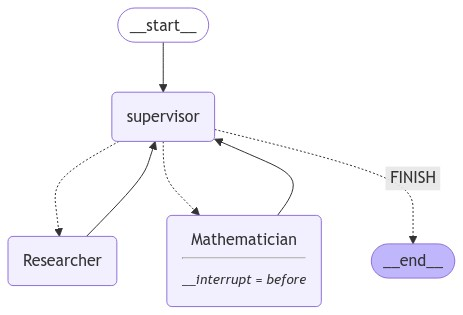

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## Let's do some research into the future of generative AI!

In [19]:
thread = {"configurable": {"thread_id": "2"}} #for memory

You'll notice that there appears to be a duplication - this is just because the supervisor first invokes the state, passes it to another agent that invokes the state again. Once this agent is done the supervisor invokes the state yet again to determine if more routing is needed or we can just end.

In [20]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Is generative AI just a gimmick? Does it have any quantifiable business value?")
        ]
    },
    thread,
    stream_mode = "values"
):
    if "__end__" not in s:
        print(s)
        print("----")

{'messages': [HumanMessage(content='Is generative AI just a gimmick? Does it have any quantifiable business value?', additional_kwargs={}, response_metadata={})]}
----
{'messages': [HumanMessage(content='Is generative AI just a gimmick? Does it have any quantifiable business value?', additional_kwargs={}, response_metadata={})], 'next': 'Researcher'}
----
{'messages': [HumanMessage(content='Is generative AI just a gimmick? Does it have any quantifiable business value?', additional_kwargs={}, response_metadata={}, id='1fff0897-471b-4424-aa43-76938877ba36'), HumanMessage(content="### Is Generative AI Just a Gimmick?\n\nGenerative AI is increasingly being recognized as more than just a gimmick. According to various sources, it is poised to disrupt numerous fields where human cognition, organization, and analysis are involved. For example:\n\n1. **Disruption Potential**: Generative AI is seen as a technology that will significantly impact various sectors, changing how tasks are performed a

In [21]:
graph_state = graph.get_state(thread)

In [22]:
graph_state.values['messages']

[HumanMessage(content='Is generative AI just a gimmick? Does it have any quantifiable business value?', additional_kwargs={}, response_metadata={}, id='1fff0897-471b-4424-aa43-76938877ba36'),
 HumanMessage(content="### Is Generative AI Just a Gimmick?\n\nGenerative AI is increasingly being recognized as more than just a gimmick. According to various sources, it is poised to disrupt numerous fields where human cognition, organization, and analysis are involved. For example:\n\n1. **Disruption Potential**: Generative AI is seen as a technology that will significantly impact various sectors, changing how tasks are performed and potentially redefining industries (Source: [LinkedIn](https://www.linkedin.com/pulse/why-gen-ai-gimmick-stephen-morison-ulxyc)).\n2. **Understanding Generative AI**: It utilizes sophisticated machine learning models to create new data rather than just making predictions, which adds to its depth and utility in real-world applications (Source: [MIT Computing](https:/

And we have chat history!

In [26]:
from IPython.display import display, Markdown

display(Markdown(graph_state.values['messages'][-1].content))

### Is Generative AI Just a Gimmick?

Generative AI is increasingly being recognized as more than just a gimmick. According to various sources, it is poised to disrupt numerous fields where human cognition, organization, and analysis are involved. For example:

1. **Disruption Potential**: Generative AI is seen as a technology that will significantly impact various sectors, changing how tasks are performed and potentially redefining industries (Source: [LinkedIn](https://www.linkedin.com/pulse/why-gen-ai-gimmick-stephen-morison-ulxyc)).
2. **Understanding Generative AI**: It utilizes sophisticated machine learning models to create new data rather than just making predictions, which adds to its depth and utility in real-world applications (Source: [MIT Computing](https://computing.mit.edu/news/explained-generative-ai/)).
3. **Examples of Use**: Companies like Google, Amazon, and Netflix integrate AI to enhance user experiences through personalized recommendations and content generation (Source: [Forbes](https://www.forbes.com/sites/bernardmarr/2023/09/19/what-is-generative-ai-a-super-simple-explanation-anyone-can-understand/)).

### Quantifiable Business Value of Generative AI

Generative AI holds substantial business value, which is becoming increasingly evident across various sectors:

1. **Early Business Value**: Organizations that have started implementing generative AI are reporting improvements in competitive positioning and the transformation of core processes and business models. This shows a shift from mere experimentation to actionable outcomes (Source: [Gartner](https://www.gartner.com/en/documents/5188263)).
2. **Wide Application**: According to a KPMG survey, generative AI is being adopted across numerous business functions, including marketing, customer support, and operations, indicating its versatility (Source: [KPMG](https://kpmg.com/kpmg-us/content/dam/kpmg/pdf/2023/generative-ai-survey.pdf)).
3. **Economic Impact**: McKinsey's analysis suggests that generative AI could significantly impact productivity across various business functions, particularly in customer interactions and operational efficiencies (Source: [McKinsey](https://www.mckinsey.com/capabilities/mckinsey-digital/our-insights/the-economic-potential-of-generative-ai-the-next-productivity-frontier)).
4. **Return on Investment (ROI)**: IBM reports that the ROI for AI has increased from 13% to 31% since 2022, highlighting the financial benefits that organizations are beginning to realize as they scale AI initiatives (Source: [IBM](https://www.ibm.com/thought-leadership/institute-business-value/en-us/report/scale-generative-ai)).

### Conclusion

Generative AI is not merely a gimmick; it has proven to be a transformative technology with substantial business value. As organizations continue to explore and implement generative AI, its impact on productivity, efficiency, and competitive advantage is expected to grow dramatically.

## Write code to do stuff!

In [27]:
for event in graph.stream(
    {
        "messages": [
            HumanMessage(
                content= "Multiply 2 and 3"
            )
        ]
    },
    thread, 
    stream_mode='values'
):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

Multiply 2 and 3


Tada it has stopped! Let's apply a state update

In [28]:
state = graph.get_state(thread)

In [29]:
state.values['messages'][-1]

HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={})

This is indeed our message. Let's update the state!

In [30]:
graph.update_state(
    thread,
    {
        "messages": [HumanMessage(
            content="No, actually multiply 3 and 3!"
        )]
    }
)

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef97555-d548-6af4-8007-07d5af8495c0'}}

### Check if state has been updated!

In [31]:
new_state = graph.get_state(thread).values

In [32]:
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Is generative AI just a gimmick? Does it have any quantifiable business value?
================================ Human Message =================================
Name: Researcher

### Is Generative AI Just a Gimmick?

Generative AI is increasingly being recognized as more than just a gimmick. According to various sources, it is poised to disrupt numerous fields where human cognition, organization, and analysis are involved. For example:

1. **Disruption Potential**: Generative AI is seen as a technology that will significantly impact various sectors, changing how tasks are performed and potentially redefining industries (Source: [LinkedIn](https://www.linkedin.com/pulse/why-gen-ai-gimmick-stephen-morison-ulxyc)).
2. **Understanding Generative AI**: It utilizes sophisticated machine learning models to create new data rather than just making predictions, which adds to its depth and utility in real-world appli

### Invoke graph on revised question
We use the trick of passing `None` to proceed!

In [33]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
================================ Human Message =================================
Name: Mathematician

The result of multiplying 3 and 3 is 9.
================================ Human Message =================================
Name: Mathematician

The result of multiplying 3 and 3 is 9.
